Estimated recurrence parameters from regression: a = 2429.419445, b = -1.727477
Scenario 1: Using T2..T2, Total Sum ≈ 8.776e+43
Scenario 2: Using T2..T3, Total Sum ≈ 1.567e+44
Scenario 3: Using T2..T4, Total Sum ≈ 2.152e+44
Scenario 4: Using T2..T5, Total Sum ≈ 2.754e+44
Scenario 5: Using T2..T6, Total Sum ≈ 3.486e+44
Scenario 6: Using T2..T7, Total Sum ≈ 4.468e+44
Scenario 7: Using T2..T8, Total Sum ≈ 5.855e+44

Power-law fit parameters for differences: C = 4.247e+43, p = -0.554
Estimated 'true sum' convergence S_inf ≈ 5.774e+44


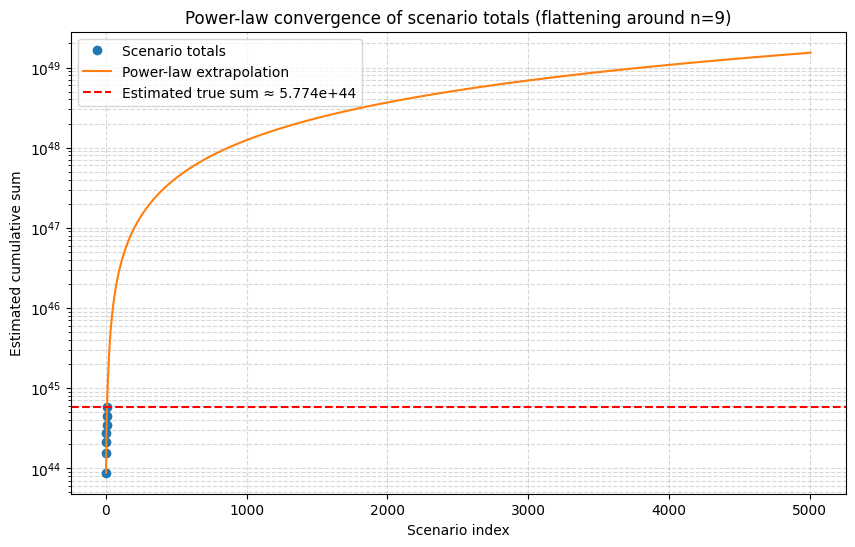

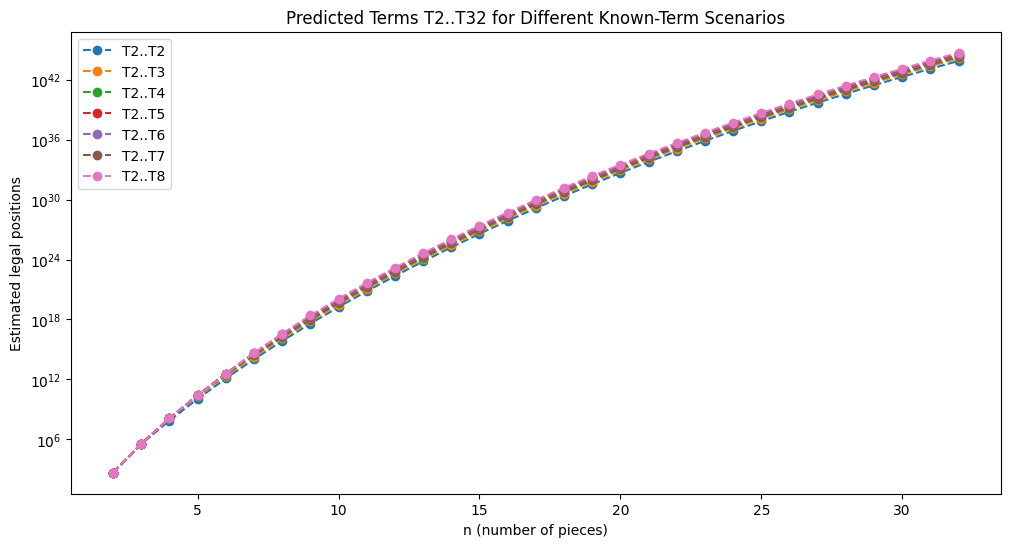

In [13]:
# Joshua Tutin and ChatGPT estimate legal chess positions:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
from scipy.special import zeta

# --- Input terms (T2..T8) ---
terms = np.array([
    462, 368079, 125246598, 25912594054,
    3787154440416, 423836835667331, 38176306877748245
])
n_vals = np.arange(2, 9)  # n=2..8

# --- Compute ratios ---
ratios = np.array([terms[i+1] / terms[i] for i in range(len(terms)-1)])
n_values = np.arange(2, 2 + len(ratios))  # n=2..7

# --- Log-log regression to get a, b ---
log_ratios = np.log(ratios)
log_n = np.log(n_values)
slope, intercept, r_value, p_value, std_err = stats.linregress(log_n, log_ratios)
a = np.exp(intercept)
b = slope
print(f"Estimated recurrence parameters from regression: a = {a:.6f}, b = {b:.6f}")

# --- Recurrence sequence generator with corrected first unknown ratio ---
def recurrence_sequence(a, b, known_terms, n_start, n_end):
    seq = list(known_terms)
    last_term = seq[-1]
    n_current = n_start + len(known_terms) - 1
    for i, n in enumerate(range(n_current + 1, n_end + 1)):
        # Correct only the first unknown ratio (T8 -> T9)
        if i == 0:
            ratio = a * (n_current ** b)  # n_current = 8 for T8 -> T9
        else:
            ratio = a * (n ** b)
        next_term = last_term * ratio
        seq.append(next_term)
        last_term = next_term
    return np.array(seq)

# --- Run scenarios ---
scenario_totals = []
all_predictions = []
labels = []

for k in range(1, len(terms)+1):
    known = terms[:k]
    predicted = recurrence_sequence(a, b, known, n_start=2, n_end=32)
    total_sum = predicted.sum()
    scenario_totals.append(total_sum)
    all_predictions.append(predicted)
    labels.append(f"T2..T{k+1}")
    print(f"Scenario {k}: Using T2..T{k+1}, Total Sum ≈ {total_sum:.3e}")

scenario_totals = np.array(scenario_totals)
scenario_indices = np.arange(1, len(scenario_totals)+1)

# --- Differences between successive totals ---
diffs = np.diff(scenario_totals)
k_fit = np.arange(1, len(diffs)+1)

# --- Fit power-law to differences, with faster flattening ---
def power_law(k, C, p):
    return C / k**p

params, _ = curve_fit(power_law, k_fit, diffs, p0=[diffs[0], 1.5])
C_fit, p_fit = params
print(f"\nPower-law fit parameters for differences: C = {C_fit:.3e}, p = {p_fit:.3f}")

# --- Estimate final sum S_inf using zeta function ---
S_inf_est = scenario_totals[-1] + C_fit * zeta(p_fit)
print(f"Estimated 'true sum' convergence S_inf ≈ {S_inf_est:.3e}")

# --- Reconstruct cumulative sum using fitted differences ---
extended_steps = 5000
diff_fit = power_law(np.arange(1, extended_steps+1), C_fit, p_fit)
S_fit = np.zeros(len(scenario_totals) + extended_steps)
S_fit[:len(scenario_totals)] = scenario_totals
for i in range(len(scenario_totals), len(S_fit)):
    S_fit[i] = S_fit[i-1] + diff_fit[i - len(scenario_totals)]

# --- Plot scenario totals with true sum line ---
plt.figure(figsize=(10,6))
plt.plot(scenario_indices, scenario_totals, 'o', label='Scenario totals')
plt.plot(np.arange(1, len(S_fit)+1), S_fit, '-', label='Power-law extrapolation')
plt.axhline(S_inf_est, color='r', linestyle='--', label=f"Estimated true sum ≈ {S_inf_est:.3e}")
plt.yscale('log')
plt.xlabel("Scenario index")
plt.ylabel("Estimated cumulative sum")
plt.title("Power-law convergence of scenario totals (flattening around n=9)")
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()

# --- Plot predicted T2..T32 sequences ---
plt.figure(figsize=(12,6))
for k, pred in enumerate(all_predictions):
    plt.plot(range(2, 33), pred, marker='o', linestyle='--', label=labels[k])
plt.yscale("log")
plt.xlabel("n (number of pieces)")
plt.ylabel("Estimated legal positions")
plt.title("Predicted Terms T2..T32 for Different Known-Term Scenarios")
plt.legend()
plt.show()
